In [8]:
!pip install mediapipe

In [10]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite


In [12]:
from google.colab import files
uploaded = files.upload()   # bilgisayarından 1+ görsel seç
list(uploaded.keys())       # yüklenen dosya adlarını gör


Saving face-3.png to face-3 (1).png
Saving face-2.png to face-2 (1).png
Saving face-1.png to face-1.png


['face-3 (1).png', 'face-2 (1).png', 'face-1.png']

face-3 (1).png: 1 yüz bulundu


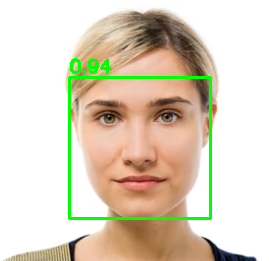

face-2 (1).png: 1 yüz bulundu


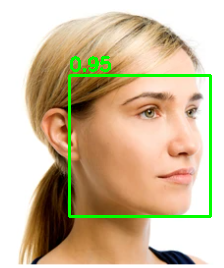

face-1.png: 1 yüz bulundu


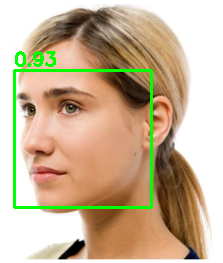

In [14]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow

# Görselleştirme yardımcı fonksiyonu
def visualize_bboxes(rgb_image, detection_result):
    img = rgb_image.copy()
    if detection_result.detections:
        for det in detection_result.detections:
            # MediaPipe Tasks FaceDetector -> bounding_box: origin_x, origin_y, width, height
            bbox = det.bounding_box
            x1, y1 = int(bbox.origin_x), int(bbox.origin_y)
            x2, y2 = x1 + int(bbox.width), y1 + int(bbox.height)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

            # İstersen puanı yaz (ilk kategori skoru)
            if det.categories:
                score = det.categories[0].score
                cv2.putText(img, f"{score:.2f}", (x1, max(0, y1-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    return img

# FaceDetector oluştur
BaseOptions = mp.tasks.BaseOptions
FaceDetectorOptions = vision.FaceDetectorOptions
FaceDetector = vision.FaceDetector
MPImage = mp.Image

MODEL_PATH = 'detector.tflite' # Define the model path

options = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path=MODEL_PATH),
    running_mode=vision.RunningMode.IMAGE
)
detector = FaceDetector.create_from_options(options)

# Yüklediğin her görsel için çalıştır
for fname in uploaded.keys():
    image = MPImage.create_from_file(fname)                # MediaPipe Image (RGB)
    result = detector.detect(image)                        # tespit
    rgb = image.numpy_view()                               # RGB array
    vis = visualize_bboxes(rgb, result)                    # kutuları çiz
    bgr = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)             # cv2_imshow BGR ister
    print(f"{fname}: {len(result.detections)} yüz bulundu")
    cv2_imshow(bgr)

In [15]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def visualize_and_classify(rgb_image, detection_result, threshold=0.03):
    """
    threshold: 0.03 = 'straight' toleransı.
    """
    img = rgb_image.copy()
    direction = "unknown"

    if detection_result.detections:
        for det in detection_result.detections:
            bbox = det.bounding_box
            x1, y1 = int(bbox.origin_x), int(bbox.origin_y)
            x2, y2 = x1 + int(bbox.width), y1 + int(bbox.height)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

            # Keypoints varsa (burnun ucu genelde index 2)
            if det.keypoints:
                nose_tip = det.keypoints[2]  # 2 = nose tip
                nose_x = nose_tip.x
                face_center_x = (bbox.origin_x + bbox.width / 2) / rgb_image.shape[1]

                offset = nose_x - face_center_x
                if offset > threshold:
                    direction = "right"
                elif offset < -threshold:
                    direction = "left"
                else:
                    direction = "straight"

                cv2.putText(img, direction, (x1, max(0, y1-10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    return img, direction


face-3 (1).png: straight


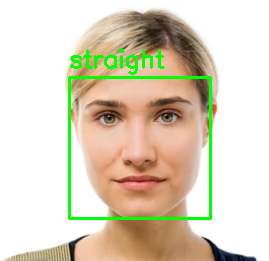

face-2 (1).png: right


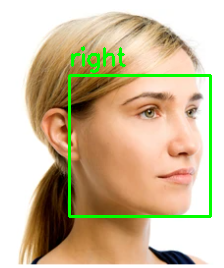

face-1.png: left


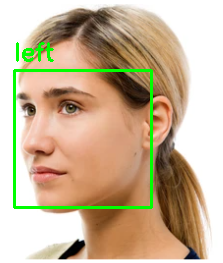

In [16]:
# Assuming 'uploaded' already has the uploaded images
for filename in uploaded.keys():
    image = mp.Image.create_from_file(filename)
    detection_result = detector.detect(image)

    rgb = image.numpy_view()
    annotated, direction = visualize_and_classify(rgb, detection_result)

    print(f"{filename}: {direction}")
    bgr = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
    cv2_imshow(bgr)
